# CPD using TIRE

In [1]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Lambda, Input, Dense
# from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences


import utils
import TIRE
from importlib import reload 

# experiments 
# import experiments.replication as x
# import experiments.each_dimensions as x
# import experiments.each_dimensions_ICA as x
# import experiments.ICA_L2 as x 
import experiments.EEG_L2 as x


## Set parameters

In [2]:
# ipynb, mỗi lần đổi code, phải restart kernal để load lại toàn bộ. Import thì chỉ lấy từ cache, ko lấy được code mới. Lý do

In [3]:
reload(x)
reload(utils)

<module 'utils' from 'c:\\Users\\Minh Nhat\\Downloads\\DCU\\Practicum\\TIRE-custom\\utils.py'>

In [2]:
workflow = x.Experiment()
workflow.set_hyperparameter_type('alpha')
workflow.hyperparams.experiment_name

'eeg_l2'

## Generate data

In [3]:
timeseries, timeseries_len, windows_TD, windows_FD = workflow.get_timeseries()

breakpoints = workflow.get_breakpoint(timeseries_len)

timeseries shape: (119496,)


In [4]:
len(breakpoints)

119297

## Train the autoencoders

In [6]:
shared_features_TD, shared_features_FD = workflow.train_autoencoder(windows_TD, windows_FD)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 100)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 3, 1)         101         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 3, 0)         0           ['input_1[0][0]']                
                                                                                                  
 tf.concat (TFOpLambda)         (None, 3, 1)         0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']            

## Postprocessing and peak detection

In [7]:
# post process for TD, FD and both, then save to file 
workflow.dissimilarities_post_process(shared_features_TD, shared_features_FD)

c:\Users\Minh Nhat\Downloads\DCU\Practicum\TIRE-custom\experiments\../data/dissimilarities_eeg_l2_alpha/dissimilarities_TD.txt
c:\Users\Minh Nhat\Downloads\DCU\Practicum\TIRE-custom\experiments\../data/dissimilarities_eeg_l2_alpha/dissimilarities_FD.txt
c:\Users\Minh Nhat\Downloads\DCU\Practicum\TIRE-custom\experiments\../data/dissimilarities_eeg_l2_alpha/dissimilarities_both.txt


In [8]:
reload(utils)

<module 'utils' from 'c:\\Users\\Minh Nhat\\Downloads\\DCU\\Practicum\\TIRE-custom\\utils.py'>

Change
mode: TD
[0.20635621166272422, 0.32901865841924, 0.41955243293271555]


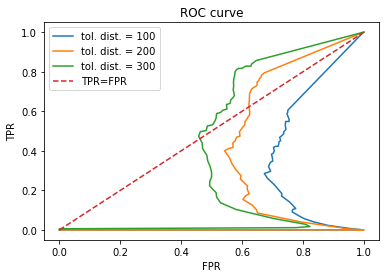

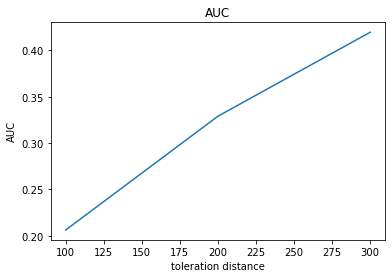

mode: FD
[0.20759083971919068, 0.3507701720313179, 0.4199250867517053]


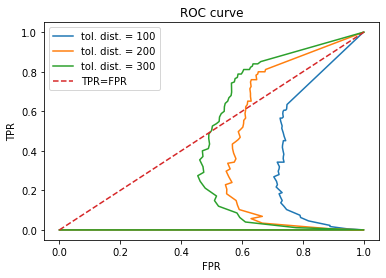

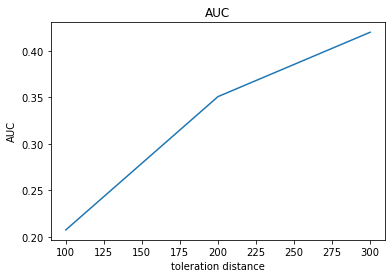

mode: both
[0.19628645272261314, 0.33176835036200736, 0.39905051510993633]


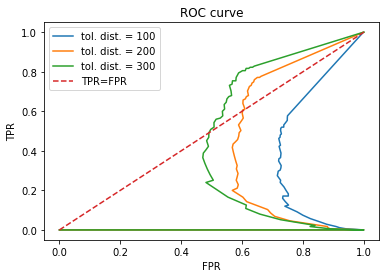

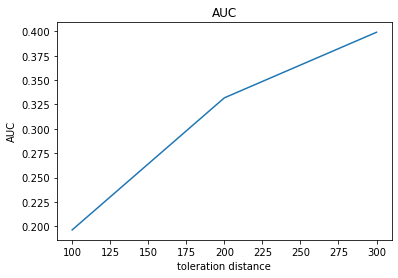

In [8]:
workflow.get_auc(breakpoints)

mode: TD


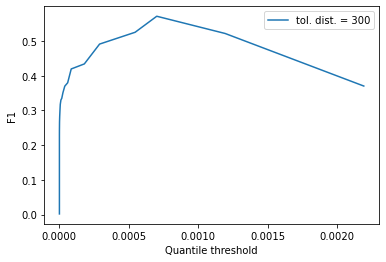

f1 max: [0.5714285714285715]
mode: FD


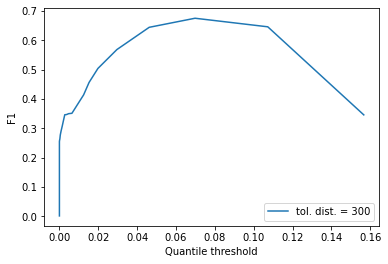

f1 max: [0.6753246753246753]
mode: both


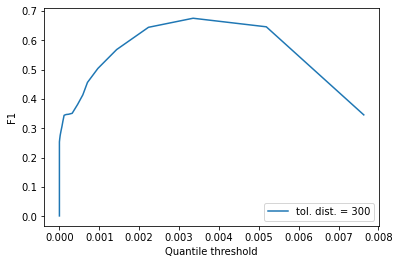

f1 max: [0.6753246753246753]


In [10]:
reload(utils)
f1s = workflow.get_f1(breakpoints)